In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## File Data

In [2]:
AUD_MAP_TYPE = 'neighbor'
HVC_COND = 'mature_hvc'
# HVC_COND = 'developing_hvc'
REC_PLASTICITY = 'EIIE'
POSTFIX = '_'.join([AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND])
IMG_DIR = '../svg/different_models/'
SONG_EMB_DIR = '../realistic_auditory_processing/learned_song_responses.npz'

## Constants

In [3]:
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
dt = 1

aud_real = np.load(SONG_EMB_DIR)
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

T_burn = 500 # Burning
T_pre = 100 # time period to keep before song
T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
T_test = T_burn+T_rend

N_test_rend = 20 if HVC_COND == 'mature_hvc' else 50

_ = np.arange(N_test_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = np.zeros((N_HVC, N_test_rend)) # auxilliary
rH = generate_HVC(T_test, burst_ts, PEAK_RATE+_, KERNEL_WIDTH+_)

cases = ('ctrl', 'pert_weak', 'pert_strong', 'deaf')
aud_args = (N_test_rend, T_burn, T_post, None, False)

## Simulations

In [4]:
tid = 0 # index of a trained network to load
res = {k: [np.zeros((N_test_rend,T_pre+T_rend,NE+i)) 
           for i in (0,NI,NI,NI)] for k in cases} 
_ = load_models('../results/', AUD_MAP_TYPE, REC_PLASTICITY, HVC_COND, tid)
nets, aud_mapping = _[:4], _[-1]

with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
    aud_real, _ = read_realistic_input(SONG_EMB_DIR, NE, mean=0, scale=2, 
                                       mapping=aud_mapping, mapping_args=None)
    aud_ctrl, aud_ctrl_idx = generate_realistic_aud(aud_real['ctrl'], *aud_args)
    aud_pert_weak, aud_pert_idx = generate_realistic_aud(aud_real['pert_weak'], *aud_args)
    aud_pert_strong, _ = generate_realistic_aud(aud_real['pert_strong'], *aud_args)
    auds = (aud_ctrl, aud_pert_weak, aud_pert_strong, aud_ctrl*0)

hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

for k, a in tqdm(zip(cases, auds), total=len(cases)):
    for i in range(a.shape[0]): # for each case, enumerate over songs
        rH_ = rH[:T_test] if k != 'playback' else rH[:T_test]*0
        args = dict(rH=rH_, aud=a[i], save_W_ts=[], T=T_test, dt=dt, 
                    noise_strength=0., no_progress_bar=True)

        with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
            # FF
            res[k][0][i] = np.hstack(nets[0].sim(hE0, **args)[:1])[T_burn-T_pre:]
            
            for j, net in enumerate(nets[1:], start=1): # EI nets
                res[k][j][i] = np.hstack(net.sim(hE0, hI0, **args)[:2])[T_burn-T_pre:]

100%|█████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]


## Analysis

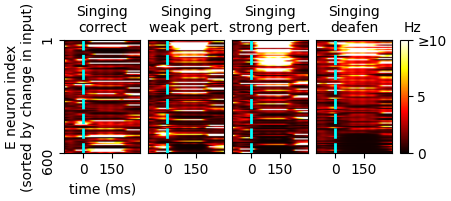

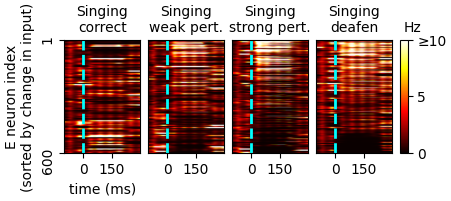

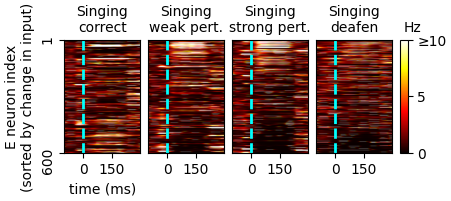

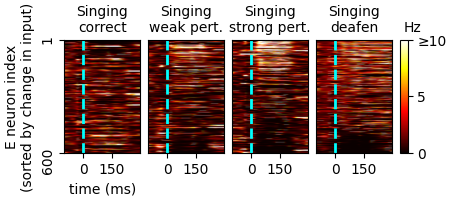

In [5]:
i = 0
titles = ['Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.', 'Singing\ndeafen']
syl = aud_real['ctrl'][:,:,PERT_T0:PERT_T1].mean(axis=(0,2))
for l, m in enumerate(('FF', 'HVC2E', 'E2E', 'E2I2E')):
    _ = [res[k][l][i,:,:NE] for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    t0, t1 = int(aud_real['pert_t0'][i]) + T_pre, int(aud_real['pert_t1'][i]) + T_pre
    bos_ctrl = aud_real['ctrl'][i,:,t0:t1].mean(axis=1)
    bos_weak_pert = aud_real['pert_weak'][i,:,t0:t1].mean(axis=1)
    bos_strong_pert = aud_real['pert_strong'][i,:,t0:t1].mean(axis=1)
    err = [bos_ctrl - syl, bos_weak_pert - syl, bos_strong_pert - syl, -syl]
    fig, ax = plot_raster_cmp_syl_dsyl(_, titles, syl, err, t0, t1+250,
                                       figsize=(4.5, 2), plot_z=False, sort_by='e', th=10, tpre=100) 
    for j in range(len(ax)-1):
        ax[j].set(xticks=[100, 250], xticklabels=[0, 150], xlabel='')
    ax[0].set(xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'err_response_%s_%s.svg' % (m, POSTFIX)))

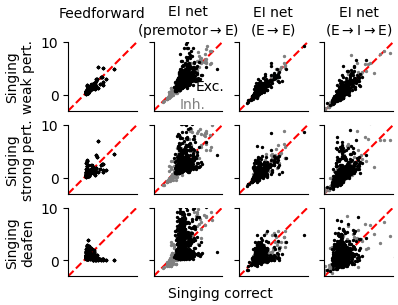

In [6]:
test_names = dict(pert_weak='Singing\nweak pert.', pert_strong='Singing\nstrong pert.', 
                  deaf='Singing\ndeafen')
model_names = ('Feedforward\n', 'EI net\n(premotor$\\to$E)', 
               'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)')
# t0, t1 = T_pre + PERT_T0, T_pre + PERT_T1
t0, t1 = T_pre, T_pre + T_song

fig, ax = plot_ctrl_vs_nonctrl(res, test_names, model_names, t0, t1, NE, figsize=(4,3))
ax[0,1].text(5, 1, 'Exc.', c='k', zorder=1)
ax[0,1].text(2, -2.5, 'Inh.', c='grey', zorder=1)
fig.savefig(os.path.join(IMG_DIR, 'learn_real_joint_dist_%s.svg' % POSTFIX), dpi=300)

2.462651512090293e-09
2.2999396437497796e-62
7.54060113978459e-17
2.766093232587594e-36


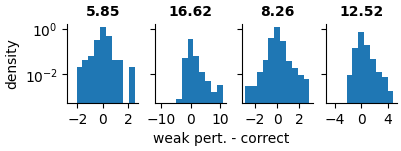

In [7]:
fig, ax = plot_dist_rate_diff(res['ctrl'], res['pert_weak'], t0, t1, NE, 
                              figsize=(4,1.5))
fig.text(0.55, 0.05, 'weak pert. - correct', ha='center')
fig.savefig(os.path.join(IMG_DIR, 'pert_diff_models_%s.svg' % POSTFIX))

0.9999999999999998
1.391681887801052e-35
0.9912462212304429
1.3592597098155992e-33


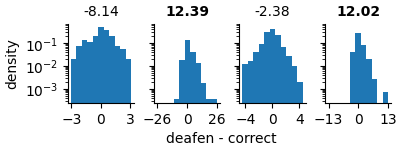

In [8]:
fig, ax = plot_dist_rate_diff(res['ctrl'], res['deaf'], t0, t1, NE, 
                              figsize=(4,1.5))
fig.text(0.55, 0.05, 'deafen - correct', ha='center')
fig.savefig(os.path.join(IMG_DIR, 'deaf_diff_models_%s.svg' % POSTFIX))

[[np.float64(0.0001), np.float64(0.0001)], [np.float64(0.0001), np.float64(0.0001)], [np.float64(0.0732), np.float64(0.9277)], [np.float64(0.0001), np.float64(0.0001)]]


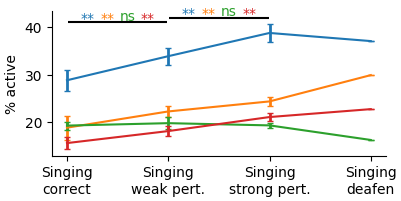

In [9]:
ls = ['Singing\ncorrect', 'Singing\nweak pert.', 
      'Singing\nstrong pert.', 'Singing\ndeafen']
fig, ax = plt.subplots(1, figsize=(4, 2))
def statistic(x, y):
    return x.mean() - y.mean()
pvs = []
for i, (m, l) in enumerate(zip(('FF', 'EI', 'EIrecEE', 'EIrecEI'), ls)):
    color = 'C%d' % i
    t0, t1 = PERT_T0+T_pre, PERT_T1+T_pre
    # data = [(res[k][i][:,t0:t1,:NE].mean(axis=1)>5).mean(axis=-1)*100
    #         for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = [(res[k][i][:,t0:t1,:NE]>3).mean(axis=(1,2))*100
            for k in ('ctrl', 'pert_weak', 'pert_strong', 'deaf')]
    data = np.stack(data)
    ax.errorbar([0,1,2,3], data.mean(axis=1), yerr=data.std(axis=1), 
                capsize=2, elinewidth=2, c=color)
    pvs.append([permutation_test([data[0], data[1]], statistic, alternative='less').pvalue, 
                permutation_test([data[1], data[2]], statistic, alternative='less').pvalue])
print(pvs)
y = ax.get_ylim()[1]-1
ax.hlines([y, y+1], [0.01, 1.01], [0.99, 1.99], color='k')
for i in range(4): # 3 models
    for j, pv in enumerate(pvs[i]):
        if pv < 0.05:
            ax.text(j+0.5+(i-1.5)*0.2, y+j, 
                    '*' if pv > 0.01 else '**', ha='center', c='C%d'%i)
        else:
            ax.text(j+0.5+(i-1.5)*0.2, y+0.5+j, 'ns', ha='center', c='C%d'%i)
ax.set(xticks=[0,1,2,3], xticklabels=ls, ylabel='% active')
fig.savefig(os.path.join(IMG_DIR, 'percent_active_%s.svg' % POSTFIX))

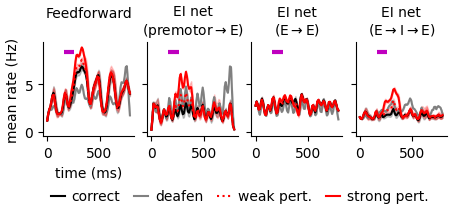

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(4.5,2), sharey='all')
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
ts = np.arange(0, T_song, 10)
for i, k in enumerate(ls):
    for j, c in zip(('deaf', 'ctrl', 'pert_weak', 'pert_strong'), ('grey', 'k', 'r', 'r')):
        aux = res[j][i][:,T_pre:-T_post:10,:NE].mean(axis=-1)
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, xs=ts,
                      ls=':' if j=='pert_weak' else '-')
    ax[i].set_rasterization_zorder(1.4)
    ax[i].set(title=k)
    
m = (aud_real['pert_t0'].mean() + aud_real['pert_t1'].mean()) / 2
for i in range(4):
    ax[i].hlines(ax[0].get_ylim()[1]-1, m-50, m+50, lw=3, color='m')
ax[0].set(xlabel='time (ms)\n', ylabel='mean rate (Hz)')
for k, c in zip(('correct', 'deafen', 'weak pert.', 'strong pert.'), ('k', 'grey', 'r', 'r')):
    ax[0].plot(0,0, c=c, ls=':' if k=='weak pert.' else '-', label=k)
fig.legend(ncols=4, loc=(0.1, -0.01), labelspacing=0.5)
fig.savefig(os.path.join(IMG_DIR, 'learn_real_mean_rates_%s.svg' % POSTFIX))

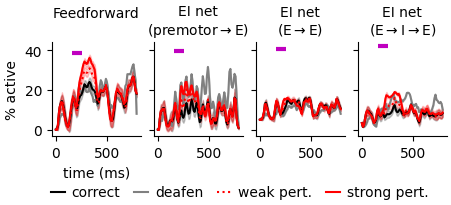

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(4.5,2), sharey='all')
ls = ['Feedforward\n', 'EI net\n(premotor$\\to$E)', 
      'EI net\n(E$\\to$E)', 'EI net\n(E$\\to$I$\\to$E)']
for i, k in enumerate(ls):
    for j, c in zip(('deaf', 'ctrl', 'pert_weak', 'pert_strong'), ('grey', 'k', 'r', 'r')):
        aux = (res[j][i][:,T_pre:-T_post:10,:NE] > 5).mean(axis=-1) * 100
        plot_mean_std(ax[i], aux.mean(axis=0), aux.std(axis=0), 0.2, c, xs=ts,
                      ls=':' if j=='pert_weak' else '-')
    ax[i].set_rasterization_zorder(1.4)
    ax[i].set(title=k)
m = (aud_real['pert_t0'].mean() + aud_real['pert_t1'].mean()) / 2
for i in range(4):
    ax[i].hlines(ax[0].get_ylim()[1]-1, m-50, m+50, lw=3, color='m')
ax[0].set(xlabel='time (ms)\n', ylabel='% active')
for k, c in zip(('correct', 'deafen', 'weak pert.', 'strong pert.'), ('k', 'grey', 'r', 'r')):
    ax[0].plot(0,0, c=c, ls=':' if k=='weak pert.' else '-', label=k)
fig.legend(ncols=4, loc=(0.1, 0), labelspacing=0.5)
fig.savefig(os.path.join(IMG_DIR, 'learn_real_sparsity_%s.svg' % POSTFIX))

730 20
600 150
371 379


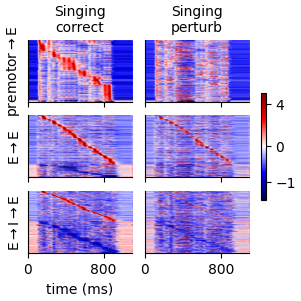

In [12]:
ks = ('ctrl', 'pert_strong')
titles = ['Singing\ncorrect', 'Singing\nperturb']

fig, ax = plt.subplots(3, len(titles), sharex='all', sharey='all', figsize=(3,3))

zs = {k: [normalize(res[k][i][0], 0) for i in (1,2,3)] for k in ks[:2]}
idxs = [temporal_sort(z, by='dmean', t0=100)[1] for z in zs['ctrl']]
norm = TwoSlopeNorm(0, -1.5, 5)
for i, k in enumerate(ks):
    ax[0,i].set_title(titles[i])
    for j, idx in enumerate(idxs):
        im = ax[j,i].imshow(zs[k][j][:,idx].T, cmap='seismic', norm=norm)
cbar = fig.colorbar(im, ax=ax, ticks=[-1, 0, 4], shrink=0.5)
ax[0,0].set(ylabel=r'premotor$\to$E')
ax[1,0].set(ylabel=r'E$\to$E')
ax[2,0].set(xticks=[0, 800], yticks=[], xlabel='time (ms)', ylabel=r'E$\to$I$\to$E')
fig.savefig(os.path.join(IMG_DIR, 'raster_%s.svg' % POSTFIX))